## HU Extension - S89A Deep Learning for NLP - Final Project

### Image Caption Generation - Data Preparation and Model Creation
#### Surya Menon

### Dataset

We use the Flickr8k Dataset, which includes photographs and around about 5 associated captions for each photograph. The dataset has been split into training (6000 images), validation (1000), and test (1000) sets which can be indexed into. You can request access to the dataset [here](https://forms.illinois.edu/sec/1713398), or from these links: [photos](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) and [captions](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)

**NOTE:**

To create and train this model, we used Google Colaboratory; we provide paths to load files for both Google Colab (by uploading necessary files directly in Files section) and alternate paths via Jupyter (to the `project_data` folder or other files in same directory as this file).

We will need the following files in our directory to load:
* `img_features.pkl` - created/saved in `project_img-features.ipynb`
* `Flickr8k.token.txt`, `Flickr_8k.trainImages.txt`, Flickr_8k.devImages.txt`, `Flickr_8k.testImages.txt`, or the associated `project_data` directory
* `Flicker8k_Dataset` folder - via the `project_data` folder, or upload individual images from this folder (i.e. `2677656448_6b7e7702af.jpg`) 
* `glove.6B.300d.txt` - download [here](https://nlp.stanford.edu/projects/glove/) and place in directory
* Model loss history files: `mod-fin_history`, `mod-fin-1_history`, `mod-fin-1-1_history` - created in this file and then reloaded later for plotting
* Final model weights: `mod-fin-ep001-loss2.588-val_loss3.214.h5` - created in this file and reloaded later for testing and evaluation

*Optional* - other files that are created in this file that can be saved and reloaded:
* Clean captions file: `captions.pkl`
* Tokenizer: `tokenizer.pkl`
* Embedding matrix: `em3500_300d.npy`

### Text Preparaton 

We previously prepared the image inputs for the model in the file `project_img-features.ipynb`. Next we clean up the caption inputs used in training the model.

First we load the captions data file, which lists the image name and each of its captions. 

**Note 1:** We need to have the appropriate files (`Flickr8k.token.txt` or its associated `project_data` folder) in our directory to run this code.

**Note 2:** When loading this dataset in Jupyter, we ran into a data rate error, which we solved by following this [link](https://www.drjamesfroggatt.com/python-and-neural-networks/iopub-data-rate-exceeded-the-notebook-server-will-temporarily-stop-sending-output-to-the-client-in-order-to-avoid-crashing-it/).

In [1]:
import os 
import string
import pickle
import numpy as np

# load dataset with captions:
def get_captions(filename):
    # open captions file and return lines
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# path to captions data
# Google Colab version (loaded into Files section)
filename = 'Flickr8k.token.txt'

# Jupyter file path - put project_data folder in same directory as this file
# filename = 'project_data\Flickr8k_text\Flickr8k.token.txt'

path = os.path.join(os.getcwd(), filename)
# get all captions
doc = get_captions(path)

# preview original captions text
doc.split('\n')[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

Next we create a dictionary that indexes by photo name and produces a full list of all associated captions. We insert start and end tokens into this file, which will be necessary for our model. We also remove punctuation and casing (to avoid duplicates and avoid increased number of tokens), and remove words that are 1 letter or contain numbers, to keep the vocabulary sensible.

In [2]:
# make captions clean 
def new_caps(s):
    # take out punctuation 
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    s = s.translate(str.maketrans('', '', string.punctuation))
    # make lower case (prevent duplicates)
    s = s.lower()
    # no words with numbers 
    s = ' '.join(w for w in s.split() if not any(d.isdigit() for d in w))
    # no 1 letter words (i.e. s that follows removed apostrophe)
    s = ' '.join(w for w in s.split() if len(w)>1)
    return s

# create dictionary of photo_id and captions
captions = dict()
# each line
for line in doc.split('\n'):
    # skip last empty line
    if len(line) < 1:
        continue
    # split on .jpg to get image name, 1st token is image id
    tokens = line.split('.')
    img_id = tokens[0]
    # check pics with no captions
    if '\t' not in tokens[1]:
        cap = tokens[1]
    # split 2nd token into descriptions, after \t, put in list    
    else: 
        cap = tokens[1].split('\t')[1]
        # make lower case, remove punctuation
        cap = new_caps(cap)
        # put start and end tokens
        cap = '< ' + cap + ' >'
    # append caption to list of associated image entry
    if img_id not in captions:
        captions[img_id] = list()
    captions[img_id].append(cap) 

# test captions dictionary
captions['997722733_0cb5439472']

['< man in pink shirt climbs rock face >',
 '< man is rock climbing high in the air >',
 '< person in red shirt climbing up rock face covered in assist handles >',
 '< rock climber in red shirt >',
 '< rock climber practices on rock climbing wall >']

We can save these captions for later use:

In [0]:
# save captions dictionary in file
pickle.dump(captions, open('captions.pkl', 'wb'))

# can reload captions here
# captions = pickle.load(open('captions.pkl', 'rb'))

### Visualizing Vocabulary

Next we will look at the vocabulary in the captions, plotting their frequencies.

In [0]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt

# create vocabulary out of all captions (8000 x # of captions per each)
vocab = set()
# go through each image caption list
for index in captions.keys():
    # add words to set from all captions
    [vocab.update(c.split()) for c in captions[index]]
    
# remove start and end tokens for visualize 
# https://www.programiz.com/python-programming/methods/set/remove
vocab.remove('<')
vocab.remove('>')

# get vocab size
print('Vocab size:', len(vocab))


# put all text in string
txt = ''
# go through each image caption list
for index in captions.keys():
    # add words to set from all captions
    t = ''.join(captions[index])
    # remove tokens from count
    t = t.translate(str.maketrans('', '', '<>'))
    txt += t

txt = txt.split(' ')

print('Total words:', len(txt))

Vocab size: 8761
Total words: 413286


We see that there are about 8761 unique words in the captions text. There are close to 414000 words in all of the text. We next visualize the word frequencies: 

[('', 40458), ('in', 18972), ('the', 18418), ('on', 10741), ('is', 9344)]


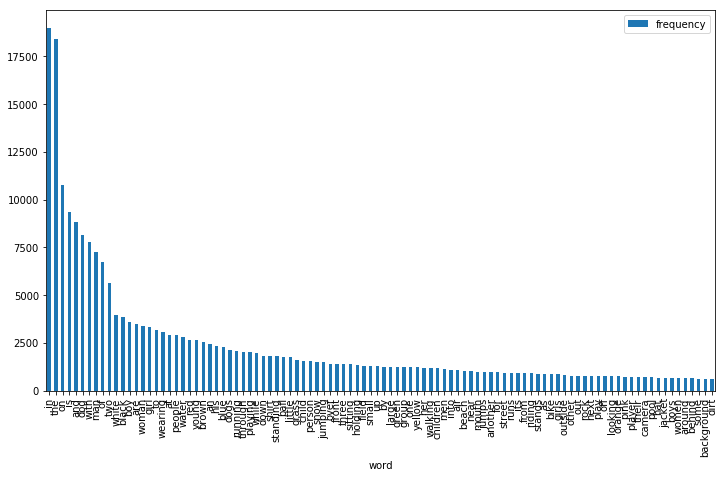

In [0]:
# get word frequencies
word_ct = nltk.FreqDist(txt)

# look at top 5 words
print(word_ct.most_common(5))

# select top 100 words (index 1 hold space so exclude)
wc = word_ct.most_common(101)[1:]

wc = pd.DataFrame(wc, columns=['word', 'frequency'])
# plot frequencies
wc.plot.bar(x='word', y='frequency', figsize=(12,7))

We see that the top token is an empty space, so we exclude this from our visualization, and visualize frequency distribution of the remaining 372828 words in the text.

Many of the words in the captions are part of the top 100 or so words, so we can reduce the vocabulary size we choose to use in the model.

### Load Training Data and Tokenize 

We load the training data by finding the associated photo identifiers and getting the corresponding captions text and photo features. We load the file `img_features.pkl` we created in `project_img-features.ipynb`, which holds compressed image features of the photo data from a pretrained convolutional neural network (CNN).

**Note:** We need to have the appropriate files (`Flickr_8k.trainImages.txt` or its associated `project_data` folder, and `img_features.pkl`) in our directory to run this code.

In [0]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# load training captions and images - defined set

# Google Colab version (loaded into Files section)
filename = 'Flickr_8k.trainImages.txt'

# Jupyter file path - put project_data folder in same directory as this file
# filename = 'project_data\Flickr8k_text\Flickr_8k.trainImages.txt'

f = os.path.join(os.getcwd(), filename)

# get (train) photo ids - put in list
def get_ids(f):
    # open file - list of training image ids
    doc = get_captions(f)
    train_ids = list()
    # by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # take out jpg ending
        train_ids.append(line.split('.')[0])  
    return train_ids

# get captions and images with associated ids
def get_data(f, captions, img_file):
    idens = get_ids(f)
    # for each id, get associated captions
    caps = {i: list(captions[i]) for i in idens} 
    # load image features file from pretrained CNN
    all_imgs = pickle.load(open(img_file, 'rb'))
    # associated id, get image feature
    imgs = {i: all_imgs[i] for i in idens}
    return idens, caps, imgs

# get training data
train_ids, train_caps, train_imgs = get_data(f, captions, 'img_features.pkl')

# double check lengths
print(len(train_ids), len(train_caps), len(train_imgs))

Using TensorFlow backend.


6000 6000 6000


We confirm that the training data consists of 6000 images.

Next we need to encode the words into integers, using the `Tokenizer` class in Keras, which we have previously seen in lecture. We first create a list of captions (from the dictionary) to encode. Then we create a tokenizer and reduce the vocabulary size to the top 3500 words and index the words. By reducing the vocabulary size, we may be able to train the model faster without wasting time on less common words.

**Note 1:** At the bottom of this next cell, there is code that is commented out to save and load our tokenizer; we can alternatively load this file instead of manually creating the `tokens` variable. 

**Note 2:** If you want to run `model_demo.ipynb`, you need to save this tokenizer file.

In [0]:
# turn caption dictionary to caption list to encode 
def dict_list(caps):
    cap_list = list()
    for index in caps.keys():
        [cap_list.append(c) for c in caps[index]]
    return cap_list

# turn training captions into list
cap_list = dict_list(train_caps)   

# preview list, length
print(len(cap_list))
print(cap_list[:3])

# use reduced vocabulary size
n_words = 3500
# include <, > as words in tokenizer, create index
tokens = Tokenizer(num_words = n_words, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

# vectorize words
tokens.fit_on_texts(cap_list)

# add 1 for 0 padding
vocab_size = n_words + 1
# double check vocab size
print(vocab_size)

# ALTERNATIVE - save/load saved tokenizer 
# pickle.dump(tokens, open('tokenizer.pkl', 'wb'))
# tokens = pickle.load(open('tokenizer.pkl', 'rb'))

30000
['< black dog is running after white dog in the snow >', '< black dog chasing brown dog through snow >', '< two dogs chase each other across the snowy ground >']
3501


### Word Embeddings

We decide to use pretrained word embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/) vectors) to represent each word/index, as we have seen in lecture; we will feed the resulting embedding matrix into our model, as opposed to learning these representations through the model. We decide to use the 300-dimensional representations. 

**Note:** At the bottom of this next cell, there is code that is commented out to save and load our embedding matrix; we can alternatively load this file instead of manually creating the matrix (which will require the file `glove.6B.300d.txt`).

In [0]:
# use pretrained word embeddings - follow lecture examples
import io

embeddings_index = {}
# Google Colab file
with io.open('/content/drive/My Drive/nlp_project_data/glove.6B.300d.txt', encoding='utf8') as f:
# Jupyter file path
# with io.open('glove.6B.300d.txt', encoding='utf8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs

# embedding dimension layer
embedding_dim = 300

# create embedding matrix with weights, of appropriate size - similar to lecture
embedding_matrix = np.zeros((vocab_size, embedding_dim))
# go through tokenizer
for w, i in tokens.word_index.items():
    embedding_vector = embeddings_index.get(w)
    # if within vocab size
    if i < vocab_size:
        if embedding_vector is not None:
          # add vector representation 
          embedding_matrix[i] = embedding_vector

# ALTERNATIVE - save/load embedding matrix
# save embeddings (can load later)
# np.save('em3500_300d.npy', embedding_matrix)
# load embedding matrix - 
# embedding_matrix = np.load('em3500_300d.npy')

# check shape
embedding_matrix.shape

(3501, 300)

### Define Model

To accomodate fitting the dataset into memory efficiently when processing through the network, we employ a data generator in training our network, which is discussed [here](https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8); essentially the optimizers will update gradients in batches of data, rather than on entire dataset. 

We define a function to calculuate the maximum caption length for the model, and view the maximum length for the training data. We also define the generator function, which prepares the inputs accordingly for a certain batch size. 

In [0]:
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers.merge import add
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, RepeatVector, Bidirectional, GRU

# look at longest caption - use as max length in model 
def max_length(caps):
    return max(len(c.split()) for c in dict_list(caps))
  
# generator to run training - can alter batch size 
def generator(captions, imgs, tokens, max_len, vocab_size, b_size=1):
    # store 2 inputs and 1 output
    inp_txt, inp_img, out = list(), list(), list()
    n = 0
    while 1:
        # go through captions and ids
        for index, caps in captions.items():
            n +=1
            # prep photo input
            img = np.array(imgs[index])
            # for each caption
            for cap in caps:
              # encode captions
              encode = tokens.texts_to_sequences([cap])[0]
              # create all possible pairs in a caption
              for i in range(1, len(encode)):
                # get all possible input/output sequences
                in_seq, out_seq = encode[:i], encode[i]
                # pad so input is fixed length
                in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                # create classification labels for output
                out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                inp_img.append(img)
                inp_txt.append(in_seq)
                out.append(out_seq)            
             # return if reach batch size
            if n == b_size:
                yield[[np.array(inp_img), np.array(inp_txt)], np.array(out)]
                # reset
                inp_txt, inp_img, out = list(), list(), list()
                n=0   

# see longest length caption in training data
print('Longest caption length:', max_length(train_caps))

Longest caption length: 34


We develop a merge model, following logics similar to what is seen [here](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/). Our network uses functional API, and take 2 inputs (a sequence and image input), and generates an additional word as an output (the caption is created a word at a time, and uses previously generated sequence as input). The structure of this model appears to be multiple input, one output, and the maximum caption length in the data is used to limit the caption size (or when an end token is reached). 


The image has been run on a pretrained CNN, and this feature representation is used as an input into the model (of size 2048), and is subsequently reduced in size using a `Dense` layer. The text input is passed into a word embedding layer (with pretrained weights that are frozen throughout training). Finally, these processed inputs (which are each of a same fixed length) are merged together. We process this concatenation using a bidirectional `GRU` layer, which is the recurrent part of the model. After this, the model has a final fully connected `Dense` layer that outputs the next word using softmax prediction (over the vocabulary size we defined).  We add `Dropout` layers to reduce overfitting. 

In [0]:
# create model 

# get max_len of sequence for training 
max_len = max_length(train_caps)

# take photo features of (2048, ) input
img_inputs = Input(shape=(2048,))
# handle overfitting 
feats1 = Dropout(0.5)(img_inputs)
# reduce size
feats2 = Dense(300, activation='relu')(feats1)
# so same size as text input when merge
feats3 = RepeatVector(max_len)(feats2)

# pass text sequences
# expect max_len inputs since padded
txt_inputs = Input(shape=(max_len,))
# put in embedding - size of vocab, 0 is padding
# add embedding matrix, freeze (don't update weights)
seq1 = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False,
                 mask_zero=True)(txt_inputs)

# merge inputs
merge1 = add([feats3, seq1])
# handle overfitting
merge2 = Dropout(0.5)(merge1)
# gru model to read sequences, make bidirectional
merge3 = Bidirectional(GRU(500, return_sequences=False))(merge2)
# generate classification/output layer
outputs = Dense(vocab_size, activation='softmax')(merge3)

# pass inputs and outputs into model
model = Model(inputs=[img_inputs, txt_inputs], outputs=outputs)

# look at layers
print(model.summary())

# compile model - set loss, optimizer, learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0005))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      dropout_1[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
repeat_vec

After defining our model, we set up our validation dataset, which should include 1000 images:

**Note:** We need to have the appropriate files (`Flickr_8k.devImages.txt` or its associated `project_data` folder, and `img_features.pkl`) in our directory to run this code.

In [0]:
# Google Colab version (loaded into Files section)
val_file = 'Flickr_8k.devImages.txt'

# Jupyter file path - put project_data folder in same directory as this file
# val_file = os.path.join(os.getcwd(), 'project_data\Flickr8k_text\Flickr_8k.devImages')

# get validation data
val_ids, val_caps, val_imgs = get_data(val_file, captions, 'img_features.pkl')

# double check lengths
print(len(val_ids), len(val_caps), len(val_imgs))

1000 1000 1000


Now we train our model. First we run the model on 5 epochs with a learning rate of 0.0005 and a batch size of 5:

In [0]:
# define epochs and batches
epochs = 5
pics_batch = 5
t_steps = len(train_caps)//pics_batch
v_steps = len(val_caps)//pics_batch

# create generators
train_g = generator(train_caps, train_imgs, tokens, max_len, vocab_size, pics_batch)
val_g = generator(val_caps, val_imgs, tokens, max_len, vocab_size, pics_batch)

# run training
history = model.fit_generator(train_g, steps_per_epoch=t_steps, epochs=epochs,
                             validation_data=val_g, validation_steps=v_steps)

Epoch 1/5
1200/1200 [==============================] - 183s 152ms/step - loss: 4.4144 - val_loss: 3.7254
Epoch 2/5
1200/1200 [==============================] - 179s 149ms/step - loss: 3.6171 - val_loss: 3.4637
Epoch 3/5
1200/1200 [==============================] - 179s 149ms/step - loss: 3.3415 - val_loss: 3.3691
Epoch 4/5
1200/1200 [==============================] - 180s 150ms/step - loss: 3.1585 - val_loss: 3.3310
Epoch 5/5
1200/1200 [==============================] - 179s 149ms/step - loss: 3.0128 - val_loss: 3.3170


In [0]:
# save first part of model, and history
model.save('mod-fin.h5')
with open('mod-fin_history', 'wb') as handle: 
    pickle.dump(history.history, handle)

We then run an additional 5 epochs with a learning rate of 0.0001:

In [0]:
# alt - load last model to continue training
# model = load_model('mod-fin.h5')

K.set_value(model.optimizer.lr, 0.0001)

history = model.fit_generator(train_g, steps_per_epoch=t_steps, epochs=epochs,
                             validation_data=val_g, validation_steps=v_steps)

Epoch 1/5
1200/1200 [==============================] - 182s 151ms/step - loss: 2.7795 - val_loss: 3.2341
Epoch 2/5
1200/1200 [==============================] - 182s 152ms/step - loss: 2.7232 - val_loss: 3.2269
Epoch 3/5
1200/1200 [==============================] - 180s 150ms/step - loss: 2.6858 - val_loss: 3.2221
Epoch 4/5
1200/1200 [==============================] - 180s 150ms/step - loss: 2.6524 - val_loss: 3.2208
Epoch 5/5
1200/1200 [==============================] - 178s 149ms/step - loss: 2.6249 - val_loss: 3.2189


In [0]:
# save next part of model, and history
model.save('mod-fin-1.h5')
with open('mod-fin-1_history', 'wb') as handle: 
    pickle.dump(history.history, handle)

Finally we run on a couple more epochs (using Early Stopping) with an increased batch size (10), and saving models with improved validation losses. 

In [0]:
# alt - load last model
# model = load_model('mod-fin-1.h5')

epochs = 5
pics_batch = 10
t_steps = len(train_caps)//pics_batch
v_steps = len(val_caps)//pics_batch

train_g = generator(train_caps, train_imgs, tokens, max_len, vocab_size, pics_batch)
val_g = generator(val_caps, val_imgs, tokens, max_len, vocab_size, pics_batch)

# save models with improved performance
filepath = 'mod-fin-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# define callbacks for tracking loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit_generator(train_g, steps_per_epoch=t_steps, epochs=epochs,
                       validation_data=val_g, validation_steps=v_steps,
                       callbacks=[early, checkpoint])

Epoch 1/5
600/600 [==============================] - 123s 205ms/step - loss: 2.5863 - val_loss: 3.2138

Epoch 00001: val_loss improved from inf to 3.21377, saving model to mod-fin-ep001-loss2.588-val_loss3.214.h5
Epoch 2/5
600/600 [==============================] - 123s 205ms/step - loss: 2.5686 - val_loss: 3.2147

Epoch 00002: val_loss did not improve from 3.21377
Epoch 3/5
600/600 [==============================] - 122s 203ms/step - loss: 2.5537 - val_loss: 3.2158

Epoch 00003: val_loss did not improve from 3.21377
Epoch 00003: early stopping


In [0]:
# save last history
# model.save('mod-fin-1-1.h5')
with open('mod-fin-1-1_history', 'wb') as handle: 
    pickle.dump(history.history, handle)

We see that the model stops improving (according to validation loss) on the 11th epoch, and we have a final training loss of 2.5537 and validation loss of 3.218. We see that there is some overfitting in this model, most likely because of the size of the dataset. We see that the best model is saved as `mod-fin-ep001-loss2.588-val_loss3.214.h5`.

We plot the losses to visualize:

**Note 1 :** Keep the above loss history files in the same directory to reload. 

**Note 2 :** If you want to run `model_demo,ipynb`, you need keep the file `mod-fin-ep001-loss2.588-val_loss3.214.h5`. 

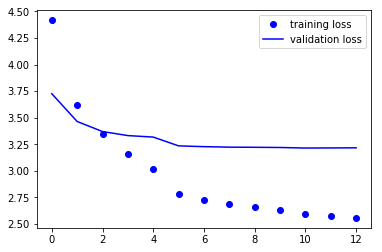

In [0]:
# includes losses from all epochs
losses1 = pickle.load(open('mod-fin_history', 'rb'))
losses2 = pickle.load(open('mod-fin-1_history', 'rb'))
# alt - losses3 = pickle.load(open('mod-fin-1-1_history', 'rb'))
losses3 = history.history

# combine losses
loss = losses1['loss'] + losses2['loss'] + losses3['loss']
val_loss = losses1['val_loss'] + losses2['val_loss'] + losses3['val_loss']

def plot_loss(loss, val):
    epochs=range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='training loss')
    plt.plot(epochs, val, 'b', label='validation loss')
    plt.legend()
    plt.show()

# plot training and validation losses
plot_loss(loss, val_loss)

We see that the model eventually stops improving (the validation loss stops decreasing), and we see overfitting after tuning with different parameters (model complexity, learning rate, etc.) and adding regularizaton (`Dropout` layers). We probably need a larger dataset in the future to improve our training.

### Model Evaluation

We next load the test data and our best model to evaluate performance. We also define a translation of word indexes back to associated words in the tokenizer. 

**Note:** We need to have the appropriate files (`Flickr_8k.testImages.txt` or its associated `project_data` folder, and `img_features.pkl`) in our directory to run this code.

In [0]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

# load test data to evaluate model

# Google Colab version (loaded into Files section)
test_file = 'Flickr_8k.testImages.txt'

# Jupyter file path - put project_data folder in same directory as this file
# test_file = os.path.join(os.getcwd(), 'project_data\Flickr8k_text\Flickr_8k.testImages')

# get test data
test_ids, test_caps, test_imgs = get_data(test_file , captions, 'img_features.pkl')

# double check lengths
print(len(test_ids), len(test_caps), len(test_imgs))

# covert index to word
def idtw(num, tokens):
    for w, i in tokens.word_index.items():
        if i == num:
            return w
    return None    

1000 1000 1000


Then we need to reload the best model created, which we previously saved

In [0]:
# load best model to test some images

# Google Colab version (loaded into Files section)
model_name = 'mod-fin-ep001-loss2.588-val_loss3.214.h5'
mod = load_model(model_name)

We define a method to create captions on some of the test images, where we pass the start token and the image feature input, and continually generate a new word to create a complete sequence.

In [0]:
# predict captions - greedy version
def make_cap(model, tokens, img, max_len):
    # start token
    in_txt='<'
    # go over entire possible sequence (of max length)
    for i in range(max_len):
        # encode input - similar set up to generator 
        seq = tokens.texts_to_sequences([in_txt])[0]
        # pad
        seq = pad_sequences([seq], maxlen=max_len)
        # get next word in sequence
        pred = model.predict([np.array(img), seq])
        # get encoded of highest probability
        pred = np.argmax(pred)
        # decode output
        w = idtw(pred, tokens)
        # break if cannot map
        if w is None:
            break
        # append to sequence
        in_txt += ' ' + w
        # stop if reach end token
        if w == '>':
            break    
    return in_txt 

Next we test on a sample test image.

**Note:** We need to have the jpg image (or the associated `Flicker8k_Dataset` folder in `project_data`) available in our directory to show the image. 

 brown dog is running through the grass 


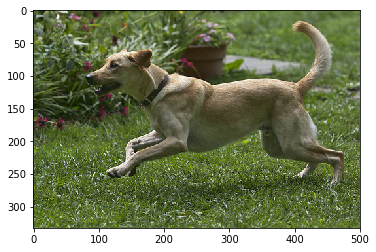

In [0]:
# try on 1 test image

# Google Colab version (loaded into Files section)
i_path='2654514044_a70a6e2c21.jpg'

# Jupyter file path - put project_data folder in same directory as this file
# i_path = os.path.join(os.getcwd(), 'project_data\Flickr8k_Dataset\Flicker8k_Dataset\\')
# i_path = os.path.join(img_folder, '2654514044_a70a6e2c21.jpg')

# in case just loading model without running training
max_len = max_length(train_caps)

# plot image
x=plt.imread(i_path)
plt.imshow(x)

# get caption
print(make_cap(mod, tokens, test_imgs['2654514044_a70a6e2c21'].reshape(1,2048), max_len)[1:-1])

We discussed BLEU scores during lecture, and according to a couple of [references](https://arxiv.org/pdf/1411.4555.pdf) including this [site](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/), we can use the [corpus BLEU scores](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/) to see how close the predicted and actual captions are to each other. We loosely follow lecture notes to create these scores:

In [0]:
# evaluate model on test images using greedy search 
def bleu(mod, test_caps, test_imgs, tokens, max_len):
    act, pred = list(), list()
    for i, caps in test_caps.items():
        img = test_imgs[i].reshape(1,2048)
        p = make_cap(mod, tokens, img, max_len)
        act.append([c.split() for c in caps])
        pred.append(p.split())
    print('BLEU-1: %f' % corpus_bleu(act, pred, weights=(1.0, 0, 0, 0)))    
    print('BLEU-2: %f' % corpus_bleu(act, pred, weights=(0.5, 0.5, 0, 0))) 
    print('BLEU-3: %f' % corpus_bleu(act, pred, weights=(0.3, 0.3, 0.3, 0))) 
    print('BLEU-4: %f' % corpus_bleu(act, pred, weights=(0.25, 0.25, 0.25, 0.25)))     

In [0]:
bleu(mod, test_caps, test_imgs, tokens, max_len)

BLEU-1: 0.583389
BLEU-2: 0.348187
BLEU-3: 0.250425
BLEU-4: 0.128517


We see that the BLEU-1 scores appear to be the best, with declining performance for subsequent n-grams. We may perhaps need larger training dataset or alternative caption searches to see improved performance. 

The above caption generation is employing a greedy search, but it has been suggested to conduct [beam serach](https://www.quora.com/Why-is-beam-search-required-in-sequence-to-sequence-transduction-using-recurrent-neural-networks) instead, which instead of taking the next mostley likely word using softmax, stores a certain number of best likely outputs at each step. Beam search is discussed more [here]( https://www.coursera.org/lecture/nlp-sequence-models/beam-search-4EtHZ). We adapt the beam search implementation used on this [site](https://medium.com/@faizanmustafa75/keras-implementation-of-image-captioning-model-3a7ab68e67d4).

In [0]:
# create beam search 
def beam_caps(model, tokens, img, max_len, beam_index=3):
    # start sequence, set probability 
    in_txt = [[tokens.texts_to_sequences(['<'])[0], 0.0]]
    
    # while less than max length
    while len(in_txt[0][0]) < max_len:
        temp = []
        # go through sequence 
        for i in in_txt:
            # pad input sequences
            seq = pad_sequences([i[0]], maxlen=max_len, padding='post')
            # get predictions for next word
            pred = model.predict([np.array(img), seq])
            # sort and pick top beam_index possibilities       
            beam_preds = np.argsort(pred[0])[-beam_index:]  
            
            # create new lists from each top pick - words and probabilities
            # build each sequence options
            for w in beam_preds:
                # get current seq, prob
                new_cap, prob = i[0][:], i[1]
                # add word and associated probability 
                new_cap.append(w)
                prob += pred[0][w]
                temp.append([new_cap, prob])
        
        # hold possibilities 
        in_txt = temp
        # sort probabilities - lambda identifies value
        in_txt = sorted(in_txt, key=lambda p: p[1])
        # pick top in full list of options
        in_txt = in_txt[-beam_index:]
  
    # pick top sequence in all
    in_txt = in_txt[-1][0]
    # decode
    inter_cap = [idtw(i, tokens) for i in in_txt]
  
    # construct caption
    final_cap = []
    for i in inter_cap:
        # if not end token
        if i != '>':
            final_cap.append(i)
        else:
            break
      
    # take out start token, make string   
    final_cap = ' '.join(final_cap[1:])
    return final_cap

We use another test image to see greedy and beam search (with various number of best states stored) results.

**Note:** We need to have the jpg image (or the associated `Flicker8k_Dataset` folder in `project_data`) available in our directory to show the image. 

Greedy:  man in black shirt is standing on the beach with the sun behind him 
Beam, k=3: two people are standing on the beach at dusk
Beam, k=5: two people are sitting on the beach next to the ocean
Beam, k=7: young boy running on the beach at sunset


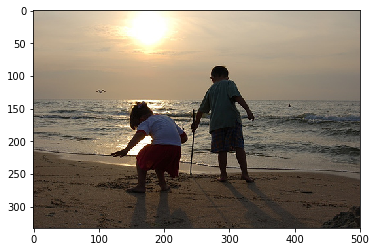

In [0]:
# test another image 

# get image path
# Google Colab version (loaded into Files section)
i_path='1322323208_c7ecb742c6.jpg'

# Jupyter file path - put project_data folder in same directory as this file
# i_path = os.path.join(os.getcwd(), 'project_data\Flickr8k_Dataset\Flicker8k_Dataset\\')
# i_path = os.path.join(img_folder, '1322323208_c7ecb742c6.jpg')

# acquire greedy and beam searches and display an image
def print_img_caps(path, mod, tokens, img, max_len):
    # plot image
    x=plt.imread(path)
    plt.imshow(x)
    # reshape image features
    img = img.reshape(1,2048)
    # get greedy caption
    txt = make_cap(mod, tokens, img, max_len)[1:-1]
    # get beam searches
    print('Greedy:', txt)
    print('Beam, k=3:', beam_caps(mod, tokens, img, max_len))
    print('Beam, k=5:', beam_caps(mod, tokens, img, max_len, beam_index=5))
    print('Beam, k=7:', beam_caps(mod, tokens, img, max_len, beam_index=7))
  
  
print_img_caps(i_path, mod, tokens, test_imgs['1322323208_c7ecb742c6'], max_len)

It seems that using beam search (in particular with beam indices of 3 or 5), may result in preferable generated captions to the greedy results in some instances.

We also evaluate the model (corpus BLEU scores) using beam search predictions (with index = 3):

**Note:** This takes a while to run, so can skip if want

In [0]:
# evaluate model on test images using beam search, beam_index=3
def bleu_2(mod, test_caps, test_imgs, tokens, max_len):
    act, pred = list(), list()
    for i, caps in test_caps.items():
        img = test_imgs[i].reshape(1,2048)
        p = beam_caps(mod, tokens, img, max_len)
        # take out start/end tokens to compare
        act.append([c[1:-1].split() for c in caps])
        pred.append(p.split())
    print('BLEU-1: %f' % corpus_bleu(act, pred, weights=(1.0, 0, 0, 0)))    
    print('BLEU-2: %f' % corpus_bleu(act, pred, weights=(0.5, 0.5, 0, 0))) 
    print('BLEU-3: %f' % corpus_bleu(act, pred, weights=(0.3, 0.3, 0.3, 0))) 
    print('BLEU-4: %f' % corpus_bleu(act, pred, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
bleu_2(mod, test_caps, test_imgs, tokens, max_len)

BLEU-1: 0.488283
BLEU-2: 0.307064
BLEU-3: 0.227320
BLEU-4: 0.116195


We do not really see an improvement in terms of these scores; although the beam search appears to produce more accurate results on the surface based on image content, these results may not exactly match the actual captions in the dataset. 

We can run a demo of the model with some random test images in the file `model_demo.ipynb`. We save the test images in a file for later loading:

**Note:** If you want to run `model_demo,ipynb`, you need to save this file.

In [0]:
# save test imgs dictionary in file
pickle.dump(test_imgs, open('test_imgs.pkl', 'wb'))